In [1]:
from metrics.em_f1 import evaluation as em_f1_eval
from run_qa import get_qa_pair

In [2]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from dotenv import load_dotenv
import os

load_dotenv()

llm = ChatOpenAI(
    api_key=os.getenv("BL_API_KEY"),
    base_url=os.getenv("BL_BASE_URL"),
    model='qwen-max-latest',
    # model='qwen-max-2025-01-25',
    # model='qwen2.5-7b-instruct',  # 小模型会有同样的效果吗  ->  不太好
    temperature=0.0
)

embed_model = OpenAIEmbeddings(
    api_key=os.getenv("BL_API_KEY"),
    base_url=os.getenv("BL_BASE_URL"),
    model="text-embedding-v3",
    dimensions=1024,
    check_embedding_ctx_length=False
)

In [3]:
# 定义向量数据库
from langchain_milvus import Milvus, BM25BuiltInFunction

vector_store = Milvus(
    collection_name='hybrid_hotpotqa500_hnsw',
    embedding_function=embed_model,
    builtin_function=BM25BuiltInFunction(output_field_names='sparse'),
    vector_field=['dense', 'sparse']
)

# 测试 LLM only

测试数据为 ../data/hotpotqa_test_data_500.json 中的前 100 个问题

In [8]:
get_qa_pair(
    qa_system=llm,
    config={},
    question_path='../data/hotpotqa_test_data_500.json',
    test_size=80,
    test_type='continue',
    # test_type='new',
    qa_res_path='./hotpotqa/llm_only/qa_result_qwen2.5-7b.json'
)

2025-08-04 11:06:00.370 | INFO     | run_qa:extract_questions:161 - 加载问题的索引为 [20:100]，共 80 个
回答问题: 100%|██████████| 80/80 [00:52<00:00,  1.51it/s]


In [9]:
em_f1_eval(
    qa_res_path='./hotpotqa/llm_only/qa_result_qwen2.5-7b.json',
    eval_res_path='./hotpotqa/llm_only/eval_result_qwen2.5-7b.json'
)

2025-08-04 11:06:54.303 | INFO     | metrics.em_f1:evaluation:127 - 加载了 100 个问答对
处理问答对: 100%|██████████| 100/100 [00:00<00:00, 311.74it/s]
2025-08-04 11:06:54.627 | INFO     | metrics.em_f1:evaluation:169 - 
 EM: 0.14 
 f1: 0.22479761904761905 
 precision: 0.2312808857808858 
 recall: 0.23777380952380953


# 测试 Naive RAG

测试数据为 ../data/hotpotqa_test_data_500.json 中的前 100 个问题

使用单密集检索

In [8]:
import sys

sys.path.append('../')

In [9]:
# 获得 Naive RAG 图
from naive_rag.workflow import get_naive_rag_workflow
from modules.retriever import Retriever

from langgraph.checkpoint.memory import MemorySaver

# 获得带有短期记忆的 Naive RAG 图
memory = MemorySaver()
naive_rag_wf = get_naive_rag_workflow()
naive_rag = naive_rag_wf.compile(checkpointer=memory)

# 定义检索器
dense_retriever = Retriever(
    vector_store=vector_store,
    topk=3,
    search_fields=['dense'],
    search_type='dense',
    search_params=[{'metric_type': 'L2', 'params': {'ef': 21}}],
)

# 定义运行时配置
config = {
    'configurable': {
        'retriever': dense_retriever,
        'llm': llm,
        'thread_id': '-1'
    }
}

In [14]:
get_qa_pair(
    qa_system=naive_rag,
    config=config,
    question_path='../data/hotpotqa_test_data_500.json',
    test_size=90,
    test_type='continue',
    # test_type='new',
    qa_res_path='./hotpotqa/naive_rag/qa_result_qwen2.5-7b.json'
)

2025-08-04 11:08:30.937 | INFO     | run_qa:extract_questions:161 - 加载问题的索引为 [10:100]，共 90 个
回答问题: 100%|██████████| 90/90 [01:15<00:00,  1.18it/s]


In [15]:
em_f1_eval(
    qa_res_path='./hotpotqa/naive_rag/qa_result_qwen2.5-7b.json',
    eval_res_path='./hotpotqa/naive_rag/eval_result_qwen2.5-7b.json'
)

2025-08-04 11:09:51.657 | INFO     | metrics.em_f1:evaluation:127 - 加载了 100 个问答对
处理问答对: 100%|██████████| 100/100 [00:00<00:00, 271.85it/s]
2025-08-04 11:09:52.033 | INFO     | metrics.em_f1:evaluation:169 - 
 EM: 0.29 
 f1: 0.4253795093795094 
 precision: 0.4441308674985146 
 recall: 0.43885714285714283


测试使用 rerank model 的 Naive RAG

测试数据为 ../data/hotpotqa_test_data_500.json 中的前 100 个问题

In [4]:
import sys

sys.path.append('../')

In [5]:
# 获得 Naive RAG 图
from naive_rag.workflow import get_naive_rag_workflow
from modules.retriever import Retriever

from langgraph.checkpoint.memory import MemorySaver

# 获得带有短期记忆的 Naive RAG 图
memory = MemorySaver()
naive_rag_wf = get_naive_rag_workflow()
naive_rag = naive_rag_wf.compile(checkpointer=memory)

# 定义检索器
rerank_model_retriever = Retriever(
    vector_store=vector_store,
    topk=3,
    search_fields=['dense', 'sparse'],
    search_type='hybrid',
    search_params=[
        {'metric_type': 'L2', 'params': {'ef': 21}},
        {'params': {'drop_ratio_search': 0.2}}
    ],
    ranker_type='model',
    ranker_params={
        'model_name': 'gte-rerank-v2',
        'pre_topk': 10,
        'pre_ranker_type': 'rrf',
        'pre_ranker_params': {'k': 60}  # 定义粗排所使用的重排序参数，粗排只能使用 weighted 或 rrf
    }
)

# 定义运行时配置
config = {
    'configurable': {
        'retriever': rerank_model_retriever,
        'llm': llm,
        'thread_id': '-1'
    }
}

In [20]:
get_qa_pair(
    qa_system=naive_rag,
    config=config,
    question_path='../data/hotpotqa_test_data_500.json',
    test_size=90,
    test_type='continue',
    # test_type='new',
    qa_res_path='./hotpotqa/naive_rag/qa_result_rerank_model_qwen2.5-7b.json'
)

2025-08-04 11:10:42.583 | INFO     | run_qa:extract_questions:161 - 加载问题的索引为 [10:100]，共 90 个
回答问题: 100%|██████████| 90/90 [01:38<00:00,  1.10s/it]


In [21]:
em_f1_eval(
    qa_res_path='./hotpotqa/naive_rag/qa_result_rerank_model_qwen2.5-7b.json',
    eval_res_path='./hotpotqa/naive_rag/eval_result_rerank_model_qwen2.5-7b.json'
)

2025-08-04 11:12:21.321 | INFO     | metrics.em_f1:evaluation:127 - 加载了 100 个问答对
处理问答对: 100%|██████████| 100/100 [00:00<00:00, 295.13it/s]
2025-08-04 11:12:21.666 | INFO     | metrics.em_f1:evaluation:169 - 
 EM: 0.35 
 f1: 0.48476479076479073 
 precision: 0.508361111111111 
 recall: 0.4945238095238095


测试使用 rerank model 的 Naive RAG

测试数据为 ../data/hotpotqa_test_data_500.json 中的前 500 个问题

In [8]:
get_qa_pair(
    qa_system=naive_rag,
    config=config,
    question_path='../data/hotpotqa_test_data_500.json',
    test_size=100,
    test_type='continue',
    # test_type='new',
    qa_res_path='./hotpotqa/naive_rag/qa_result_rerank_model_qwenmax0125.json'
)

2025-08-04 16:01:05.724 | INFO     | run_qa:extract_questions:161 - 加载问题的索引为 [400:500]，共 100 个
回答问题: 100%|██████████| 100/100 [01:52<00:00,  1.13s/it]


In [9]:
em_f1_eval(
    qa_res_path='./hotpotqa/naive_rag/qa_result_rerank_model_qwenmax0125.json',
    eval_res_path='./hotpotqa/naive_rag/eval_result_rerank_model_qwenmax0125.json'
)

2025-08-04 16:03:01.457 | INFO     | metrics.em_f1:evaluation:127 - 加载了 500 个问答对
处理问答对: 100%|██████████| 500/500 [00:01<00:00, 321.86it/s]
2025-08-04 16:03:03.013 | INFO     | metrics.em_f1:evaluation:169 - 
 EM: 0.492 
 f1: 0.6454396762107288 
 precision: 0.6421265215176979 
 recall: 0.6948523809523809


# 测试 RAG with Judge

测试数据为 ../data/hotpotqa_test_data_500.json 中的前 100 个问题

使用 rerank model 重排

In [4]:
import sys

sys.path.append('../')

In [5]:
# 获得 RAG with Judge 图
from rag_with_judge.workflow import get_rag_with_judge_workflow
from modules.retriever import Retriever

from langgraph.checkpoint.memory import MemorySaver

# 获得带有短期记忆的 RAG with Judge 图
memory = MemorySaver()
rag_with_judge_wf = get_rag_with_judge_workflow()
rag_with_judge = rag_with_judge_wf.compile(checkpointer=memory)

# 定义检索器
rerank_model_retriever = Retriever(
    vector_store=vector_store,
    topk=3,
    search_fields=['dense', 'sparse'],
    search_type='hybrid',
    search_params=[
        {'metric_type': 'L2', 'params': {'ef': 21}},
        {'params': {'drop_ratio_search': 0.2}}
    ],
    ranker_type='model',
    ranker_params={
        'model_name': 'gte-rerank-v2',
        'pre_topk': 10,
        'pre_ranker_type': 'rrf',
        'pre_ranker_params': {'k': 60}  # 定义粗排所使用的重排序参数，粗排只能使用 weighted 或 rrf
    }
)

# 定义运行时配置
config = {
    'configurable': {
        'retriever': rerank_model_retriever,
        'llm': llm,
        'thread_id': '-1',
        'graph': rag_with_judge,
        'recursion_depth': 0,
        'max_rec_depth': 5
    }
}

In [39]:
# 实际使用的是 qwen-max-latest，不然总是容易达到 limit_requests
# 两个模型的实际性能也差不多
get_qa_pair(
    qa_system=rag_with_judge,
    config=config,
    question_path='../data/hotpotqa_test_data_500.json',
    test_size=10,
    test_type='continue',
    # test_type='new',
    qa_res_path='./hotpotqa/rag_with_judge/qa_result_rerank_model_qwen2.5-7b.json'
)

2025-08-04 12:36:51.952 | INFO     | run_qa:extract_questions:161 - 加载问题的索引为 [90:100]，共 10 个
回答问题:   0%|          | 0/10 [00:00<?, ?it/s]

回答问题:  90%|█████████ | 9/10 [00:26<00:03,  3.00s/it]

使用 f389b71d-f658-43e5-950a-866ca9f4cbd7 调用 RAG，问题为 迈克尔的祖父作为国王出生在什么日期和哪一年？，当前递归深度为 1


回答问题: 100%|██████████| 10/10 [00:34<00:00,  3.49s/it]


In [6]:
rag_with_judge.invoke(
    input={'query': 'A sparse image is used by the FileVault feature in Mac OS X in versions later than which?'},
    config=config
)

使用 b30595c6-babe-4e28-b4a5-9f9e2ff122a2 调用 RAG，问题为 Which Mac OS X version stopped using sparse images for FileVault?，当前递归深度为 1
使用 2afcbbc8-c31c-4456-9252-d82b42666daf 调用 RAG，问题为 Which Mac OS X version first used a sparse image with FileVault?，当前递归深度为 1
使用 fe1ddb51-55c5-49cd-a05f-07244f1d121e 调用 RAG，问题为 Which Mac OS X version first introduced FileVault with sparse image?，当前递归深度为 2
使用 80795283-ac62-4112-bfc0-07dd0a22c67b 调用 RAG，问题为 What Mac OS X version introduced FileVault with sparse image?，当前递归深度为 2
使用 1dd66fdc-010d-4790-b629-7ad0a1045a30 调用 RAG，问题为 Which Mac OS X version changed FileVault's storage method?，当前递归深度为 2
使用 d3155de7-1ef2-4bf2-8876-0b4d3b761ca5 调用 RAG，问题为 Which Mac OS X version first replaced sparse images with a new FileVault approach?，当前递归深度为 2
使用 8ec53a97-7c52-45ff-a874-dfddeacceec8 调用 RAG，问题为 Which Mac OS X version first introduced FileVault with sparse image?，当前递归深度为 3
使用 82698748-9620-4d91-acb7-c53aa313ae9c 调用 RAG，问题为 Which Mac OS X version first introduced FileVault

{'messages': [SystemMessage(content='You are a RAG Q&A assistant that operates strictly according to the following rules:\n1. Use only the knowledge provided by the user to answer questions, including the retrieved raw knowledge snippets and the added Q&A pairs (the **answer part is considered supplementary knowledge**, and only the content of the answer should be used). Do not use any external knowledge.\n2. If there is no information in all the knowledge (raw snippets + answers from Q&A pairs) that can answer the question, you must respond with "I cannot answer this question."\n3. The response must be concise and direct: output only the final answer, without explanations, references to the knowledge, or polite language.\n4. If the knowledge is irrelevant to the question, immediately trigger rule 2.', additional_kwargs={}, response_metadata={}, id='346f621f-b60b-43cd-b3f0-961e1b1d289b'),
  HumanMessage(content="[Knowledge]\nknowledge 0: A sparse image is a type of disk image file used

In [7]:
em_f1_eval(
    qa_res_path='./hotpotqa/rag_with_judge/qa_result_rerank_model_qwen2.5-7b.json',
    eval_res_path='./hotpotqa/rag_with_judge/eval_result_rerank_model_qwen2.5-7b.json'
)

2025-08-04 15:02:11.431 | INFO     | metrics.em_f1:evaluation:127 - 加载了 100 个问答对
处理问答对: 100%|██████████| 100/100 [00:00<00:00, 275.53it/s]
2025-08-04 15:02:11.831 | INFO     | metrics.em_f1:evaluation:169 - 
 EM: 0.31 
 f1: 0.4824747442100383 
 precision: 0.48235914085914083 
 recall: 0.5470238095238095


小模型不能：

1. 很好的发挥 Judge 的作用，无法准确的判断当前文档对回答问题的帮助程度

2. 很好的提出新问题。所提的问题中有很多指代类型的词（比如他、那本书）

对于小模型来说，如果不能微调的话，需要好好的设计对应的提示词

测试数据为 ../data/hotpotqa_test_data_500.json 中的前 500 个问题

使用 rerank model 重排

In [30]:
# 实际使用的是 qwen-max-latest，不然总是容易达到 limit_requests
# 两个模型的实际性能也差不多
get_qa_pair(
    qa_system=rag_with_judge,
    config=config,
    question_path='../data/hotpotqa_test_data_500.json',
    test_size=50,
    test_type='continue',
    # test_type='new',
    qa_res_path='./hotpotqa/rag_with_judge/qa_result_rerank_model_qwenmax0125.json'
)

2025-08-04 16:26:01.206 | INFO     | run_qa:extract_questions:161 - 加载问题的索引为 [450:500]，共 50 个
回答问题:   0%|          | 0/50 [00:00<?, ?it/s]

回答问题:   4%|▍         | 2/50 [00:07<02:42,  3.38s/it]

使用 5e6942c9-b3ee-46fd-823f-36a1b9a3b038 调用 RAG，问题为 When was 2PM's DVD 'Take Off' released?，当前递归深度为 1


回答问题:  14%|█▍        | 7/50 [00:33<04:00,  5.60s/it]

使用 e5771ed5-8511-4c0a-9318-6a374c73cbaf 调用 RAG，问题为 Was Life magazine published monthly in 1998?，当前递归深度为 1
使用 c21c744c-e5fb-43ec-8797-670d3a40d29b 调用 RAG，问题为 Was Strictly Slots magazine published monthly in 1998?，当前递归深度为 1


回答问题:  18%|█▊        | 9/50 [00:48<04:19,  6.34s/it]

使用 02aa0c75-0026-4de8-9440-4d7052d129a2 调用 RAG，问题为 When did the Salmita Mine begin operations?，当前递归深度为 1使用 66a8b54e-9d4e-489f-9a9c-94a4ab9168a5 调用 RAG，问题为 When was the Salmita Mine in service?，当前递归深度为 1



回答问题:  20%|██        | 10/50 [00:55<04:17,  6.44s/it]

使用 1c539595-4b6c-4f29-827d-234887206961 调用 RAG，问题为 What audience does Alice Hoffman's writing target?，当前递归深度为 1
使用 3dfa0939-9e0e-44da-b1cb-fb235f916828 调用 RAG，问题为 What are the primary themes and audience of Alice Hoffman's writing?，当前递归深度为 1
使用 7519c516-4c0c-4030-9b01-a85d80e2d2da 调用 RAG，问题为 Who is Maurice Level and what audience does his work target?，当前递归深度为 1
使用 e1656861-bc1d-47dc-93d9-8d70c1ec725b 调用 RAG，问题为 What audience does Maurice Level's work target?，当前递归深度为 2
使用 6a8f4c68-00f1-422b-b044-e96bd0b1f369 调用 RAG，问题为 What audience does Maurice Level's work target?，当前递归深度为 2
使用 a2c1b976-a363-433a-82f9-e9c97f18abc3 调用 RAG，问题为 Who is the target audience of Alice Hoffman's works?，当前递归深度为 2
使用 b3592572-6234-4791-bf49-0862502ac3ce 调用 RAG，问题为 What are the primary themes in Alice Hoffman's other works and her target audience?，当前递归深度为 2
使用 e447a275-7e31-4f09-8c59-1bdc1cd11c24 调用 RAG，问题为 What age groups or demographics does Alice Hoffman focus on?，当前递归深度为 2
使用 d9192987-3127-4fde-b990-7d950fc979

回答问题:  22%|██▏       | 11/50 [01:30<09:53, 15.21s/it]

使用 5024f8f3-7083-4b1c-94ce-e350848fca29 调用 RAG，问题为 Who were the spouses of the main actors in Marcus Welby, M.D.?，当前递归深度为 1
使用 5b6173f7-3b87-428a-be90-03486df851eb 调用 RAG，问题为 Who was John F. Nolan married to?，当前递归深度为 1
使用 3d20b6d3-0569-4b40-9179-feef70193d56 调用 RAG，问题为 Who were the main actors in Marcus Welby, M.D. and their spouses?，当前递归深度为 2
使用 cb381399-085f-4e0c-8db9-9dc73f845adc 调用 RAG，问题为 Who were the spouses of Robert Young, James Brolin, and Elena Verdugo?，当前递归深度为 3
使用 ca8d29e5-2be7-414c-b0e8-5f04d99aa50a 调用 RAG，问题为 Who were the other main actors in Marcus Welby, M.D. and their spouses?，当前递归深度为 3
使用 90ae3edc-105e-4ade-b39f-ed2736a3212c 调用 RAG，问题为 Who were the main actors in Marcus Welby, M.D. and their spouses?，当前递归深度为 3
使用 f76b74cf-45b7-4669-84a0-55278e2c8c07 调用 RAG，问题为 Who were the spouses of Robert Young and Elena Verdugo?，当前递归深度为 4
使用 a133b07d-f1ac-4515-a84f-63d623bcea41 调用 RAG，问题为 Who were the spouses of Robert Young, James Brolin, and Elena Verdugo?，当前递归深度为 4
使用 55db6b9d-e

回答问题:  26%|██▌       | 13/50 [02:11<10:10, 16.49s/it]

使用 38fe139f-aff7-4c36-88e9-b6d999a25835 调用 RAG，问题为 What is the noted aspect of the band addressed by Brad Elterman?，当前递归深度为 1
使用 8b1ce0d0-66ba-4e5a-a877-3674a285442b 调用 RAG，问题为 What specific aspect of the rock 'n' roll lifestyle did Brad Elterman focus on in his photography?，当前递归深度为 2
使用 11bcbd98-c8c2-4bd7-b95b-a76be8d13b37 调用 RAG，问题为 What themes or elements of rock 'n' roll lifestyle did Brad Elterman emphasize in his photos?，当前递归深度为 3
使用 38a2c591-f2f7-477f-86ad-18ae561f1b52 调用 RAG，问题为 What specific themes did Elterman focus on in his photography?，当前递归深度为 4


回答问题:  28%|██▊       | 14/50 [02:32<10:41, 17.82s/it]

使用 4cc25646-ff2d-4683-b24c-85131ec4e4ec 调用 RAG，问题为 Who voiced Bugs Bunny in the 1946 cartoon?，当前递归深度为 1使用 12d5f37c-d1dd-45df-8751-efc25d04c406 调用 RAG，问题为 Who voiced Bugs Bunny in 'Baseball Bugs'?，当前递归深度为 1

使用 94f02d9d-8ce7-4154-b316-d5314fbbd1c5 调用 RAG，问题为 Who was the voice actor for Bugs Bunny in 1946?，当前递归深度为 2
使用 fad4afb6-afaa-42d6-809c-a4f83f47bbb3 调用 RAG，问题为 Who voiced Bugs Bunny in the 1946 short 'Baseball Bugs'?，当前递归深度为 2


回答问题:  30%|███       | 15/50 [02:43<09:07, 15.64s/it]

使用 3c6e90e7-5de0-4ae0-a105-be4bdb2ed49f 调用 RAG，问题为 Who is the actress joining the DCEU after starring in other franchises?，当前递归深度为 1
使用 43b7e974-34c4-4d07-8e84-2ac011686afb 调用 RAG，问题为 Who is the actress joining the DCEU after Gadot?，当前递归深度为 1
使用 c69105c7-30e3-4356-80bf-ce89340417ab 调用 RAG，问题为 Who is the next actress after Gadot in DCEU?，当前递归深度为 2
使用 f287cb22-37cd-418e-93fe-e0819f50f647 调用 RAG，问题为 Which franchises did Gal Gadot star in before joining the DCEU?，当前递归深度为 2
使用 c064c87a-7384-4617-b7e1-26876cd6b63d 调用 RAG，问题为 Which actress in the cast of Batman v Superman: Dawn of Justice has starred in other franchises?，当前递归深度为 2
使用 9224d9ef-514f-4bd6-94f1-89b02e1be7f9 调用 RAG，问题为 Which franchises have the actresses in Batman v Superman: Dawn of Justice starred in?，当前递归深度为 3
使用 d73d7dd9-35af-4dab-8da5-71691d5d8765 调用 RAG，问题为 Which franchises have Holly Hunter and Gal Gadot starred in?，当前递归深度为 3
使用 c2d69b9f-02c6-4be2-9224-c6e25c3ea71f 调用 RAG，问题为 Did Gal Gadot-Varsano star in Batman v Superman:

回答问题:  32%|███▏      | 16/50 [03:13<11:22, 20.09s/it]

使用 6b3972ef-80bc-4bb7-9b90-3eeef1399c06 调用 RAG，问题为 Which film festival did Il divo premiere at?，当前递归深度为 1使用 759f7ef4-b5f6-492a-8663-2c7922a41eee 调用 RAG，问题为 Which movie did Carlo Buccirosso act in that premiered at a film festival?，当前递归深度为 1

使用 d577b7ea-8725-4480-87b2-0cf2113c5369 调用 RAG，问题为 What is the name of the film festival in Santa Monica?，当前递归深度为 2
使用 49fcaf93-1f96-4eaf-862c-12acaa145e50 调用 RAG，问题为 Which of Carlo Buccirosso's movies premiered at a film festival?，当前递归深度为 2
使用 16d4617e-0093-4319-a334-d538ce008649 调用 RAG，问题为 What role did Carlo Buccirosso play in The Great Beauty?，当前递归深度为 2
使用 4822a74d-adee-46b5-8852-04e03458f446 调用 RAG，问题为 Which film festival did 'Un'estate ai Caraibi' premiere at?，当前递归深度为 2
使用 54262df0-56b0-4367-95d3-f1bd135111c8 调用 RAG，问题为 Which of Carlo Buccirosso's movies premiered at a film festival?，当前递归深度为 3
使用 32d8dd88-9e28-48c1-990f-62b939988a59 调用 RAG，问题为 What role did Carlo Buccirosso play in The Great Beauty?，当前递归深度为 3
使用 98d16265-abe1-413d-80d5-e85bdb

回答问题:  46%|████▌     | 23/50 [03:56<02:15,  5.01s/it]

使用 7f1594a9-aa67-4050-a323-894c0d3e7e87 调用 RAG，问题为 Who is the creator or author of Johnny Tremain?，当前递归深度为 1
使用 5e869db0-2101-4592-b02f-3b7e39308a31 调用 RAG，问题为 Who founded Walt Disney Productions and contributed to the Magic Kingdom?，当前递归深度为 1


回答问题:  48%|████▊     | 24/50 [04:05<02:38,  6.08s/it]

使用 fa811baa-b72d-4610-8add-9a2d6fb093f0 调用 RAG，问题为 What did the Bangor Daily News say about Sawin Millett's political influence?，当前递归深度为 1


回答问题:  52%|█████▏    | 26/50 [04:18<02:27,  6.14s/it]

使用 213fca3f-e72b-4c4e-9d20-68e0b2220cbe 调用 RAG，问题为 What is the name of the helmet discovered in 1939 that is well preserved and associated with the Coppergate Helmet?，当前递归深度为 1
使用 83e7787f-ebc3-4acf-aa3f-e84b6ce44430 调用 RAG，问题为 What is the Coppergate Helmet and how is it related to the Sutton Hoo helmet?，当前递归深度为 1
使用 a5f6ab01-e991-4f0d-bca2-0cab8053b722 调用 RAG，问题为 What helmet was discovered in 1939 and is often mentioned alongside the Coppergate Helmet?，当前递归深度为 1
使用 d759da16-902b-4e3c-8231-23389697892f 调用 RAG，问题为 How does the Coppergate Helmet compare to the Sutton Hoo helmet in terms of design and historical significance?，当前递归深度为 2
使用 82dab87a-0089-4b4f-9dea-289479efb54b 调用 RAG，问题为 What are the key features and historical significance of the Coppergate Helmet?，当前递归深度为 2
使用 3ba133e9-8729-497d-8913-40872a324515 调用 RAG，问题为 What is the name of the helmet found in 1939?，当前递归深度为 2
使用 6becb743-7f5e-4f14-85d6-da2e4c80da39 调用 RAG，问题为 How is the Sutton Hoo helmet related to the Coppergate Helme

2025-08-04 16:31:08.550 | ERROR    | run_qa:get_qa_pair:116 - Whose helmet is it discovered in 1939 which is well preserved and together with the Coppergate Helmet? 出现错误 Error code: 429 - {'error': {'message': 'You exceeded your current requests list.', 'type': 'limit_requests', 'param': None, 'code': 'limit_requests'}, 'request_id': '6cf131ab-2121-95bd-82c3-ec33ccd83831'}
回答问题:  58%|█████▊    | 29/50 [05:14<03:52, 11.07s/it]

使用 22a39963-aade-4c05-a3bc-c0eb7cc65ca2 调用 RAG，问题为 What school of work did Heinrich Marschner's predecessor belong to?，当前递归深度为 1使用 e6a8b8b2-7d81-4864-842c-c225ac10164c 调用 RAG，问题为 What school of music did Heinrich Marschner belong to?，当前递归深度为 1
使用 50492195-640c-4a8e-884d-5bcdd8c8bbb4 调用 RAG，问题为 What school of work did Heinrich Marschner belong to?，当前递归深度为 1

使用 3d35fbed-c586-4578-885f-679beffce521 调用 RAG，问题为 What school of work did Carl Maria von Weber belong to?，当前递归深度为 2
使用 a392b06d-ba89-481d-92b7-d8149eb1d64f 调用 RAG，问题为 What are the defining characteristics of the German opera school between Weber and Wagner?，当前递归深度为 2
使用 f6878277-84de-4df1-b62b-2ebe5c76188a 调用 RAG，问题为 What is the specific school of work associated with German Romantic opera?，当前递归深度为 2
使用 7a3c8498-379c-42a9-a3e5-49668a967c41 调用 RAG，问题为 What defines the German Romantic opera school?，当前递归深度为 3
使用 a7beb76e-2cfd-4c00-b250-7cd9c3bde61f 调用 RAG，问题为 What defines German Romantic opera?，当前递归深度为 3
使用 c90c1258-2f19-4f01-84ef-4bc

回答问题:  60%|██████    | 30/50 [05:48<06:03, 18.15s/it]

使用 7dd9943c-dcf2-45cb-b47c-4c55ab23c61d 调用 RAG，问题为 What city is associated with Albany County?，当前递归深度为 1
使用 8a57dc3a-d172-4e84-b8a9-b292ef117f87 调用 RAG，问题为 Where is Paul Clyne from?，当前递归深度为 1
使用 76f53395-1bc6-4c40-8345-868737b475f2 调用 RAG，问题为 Is Paul Clyne originally from Albany, New York?，当前递归深度为 2


回答问题:  62%|██████▏   | 31/50 [05:59<05:00, 15.80s/it]

使用 d3062d38-4f98-4b0f-87eb-fefff1de8819 调用 RAG，问题为 Who was the second-year head coach of the Oregon Ducks during the 2014 season?，当前递归深度为 1使用 ba122932-1ae6-4379-b32f-8374740f12d7 调用 RAG，问题为 Did the 2014 Oregon Ducks win the Pac-12 Conference title?，当前递归深度为 1



回答问题:  68%|██████▊   | 34/50 [06:13<02:10,  8.15s/it]

使用 8e845e8f-0afb-499b-9286-c50a9ec978d9 调用 RAG，问题为 How many members are in World Party?，当前递归深度为 1使用 7661ac7d-eb1e-4096-be41-cb512d5da971 调用 RAG，问题为 How many members are in Dashboard Confessional?，当前递归深度为 1



回答问题:  70%|███████   | 35/50 [06:21<02:00,  8.05s/it]

使用 c8bc2aee-4f92-484b-9afa-c46532b82960 调用 RAG，问题为 Is Izze an artificially flavored soft drink?，当前递归深度为 1使用 9f2c793c-99f5-480a-90b8-0ab72c68d6e7 调用 RAG，问题为 Is Grapico artificially flavored?，当前递归深度为 1



回答问题:  72%|███████▏  | 36/50 [06:29<01:54,  8.20s/it]

使用 f679a1dd-2b18-42f8-8fe5-e03b321b07b2 调用 RAG，问题为 Who else is represented by Amal Clooney besides Assange, Tymoshenko, and Fahmy?，当前递归深度为 1
使用 a8369405-81c4-4212-b78a-18c75b5f7364 调用 RAG，问题为 Who are other notable clients represented by Amal Clooney?，当前递归深度为 2
使用 6e7c1f51-51e8-47da-84cd-7252352283bc 调用 RAG，问题为 Who are other high-profile individuals Amal Clooney has represented?，当前递归深度为 3
使用 e6a0bc32-bdfd-40d7-8079-6b218f7a7698 调用 RAG，问题为 What other notable clients has Amal Clooney represented besides Julian Assange, Yulia Tymoshenko, and Mohamed Fahmy?，当前递归深度为 4


回答问题:  74%|███████▍  | 37/50 [06:46<02:18, 10.67s/it]

使用 2b2197eb-d675-41a4-9ac3-78dc7f041806 调用 RAG，问题为 Where is Audioslave from?，当前递归深度为 1
使用 6b60be1a-7787-409c-9e6b-fc7c84e9c4a8 调用 RAG，问题为 Where is Halestorm from?，当前递归深度为 1
使用 7b26bed5-f161-41a5-a976-0bbde08c730e 调用 RAG，问题为 Where is Halestorm from?，当前递归深度为 1


回答问题:  80%|████████  | 40/50 [07:00<01:05,  6.57s/it]

使用 841b9ce4-df71-4ce7-8a12-10538e517c24 调用 RAG，问题为 Who is the captain of MLS club Colorado Rapids?，当前递归深度为 1


回答问题:  82%|████████▏ | 41/50 [07:05<00:55,  6.22s/it]

使用 3f57f035-a680-4484-9595-ee046adeb404 调用 RAG，问题为 When did the fifteenth season of The Simpsons begin?，当前递归深度为 1
使用 9b409d23-d284-4572-b1b9-c75766c65d88 调用 RAG，问题为 When did the season containing 'Co-Dependents' Day' start?，当前递归深度为 1
使用 299b566d-6925-4d84-b914-103fb40c8ef9 调用 RAG，问题为 When did the fifteenth season of 'The Simpsons' start?，当前递归深度为 2
使用 fc27f0f6-5de6-448d-937b-fe1902e41308 调用 RAG，问题为 Which season does 'Co-Dependents' Day' belong to?，当前递归深度为 2


回答问题:  86%|████████▌ | 43/50 [07:20<00:46,  6.59s/it]

使用 ddf33dd2-3cc1-47de-aeeb-8571e7a1cf16 调用 RAG，问题为 Which suburb of Adelaide in the City of Norwood Payneham St Peters is included in the electoral district of Dunstan?，当前递归深度为 1使用 ad2a66b2-12be-4d8d-98e5-3717de5892fb 调用 RAG，问题为 Which electoral district includes the suburb of St Peters in the City of Norwood Payneham St Peters?，当前递归深度为 1
使用 3f002186-04d3-439d-a9e0-e611ba52588e 调用 RAG，问题为 Which suburb is included in the electoral district of Dunstan?，当前递归深度为 1

使用 b5de5d7a-a3b8-4482-86fb-3d3826471b4b 调用 RAG，问题为 Which suburbs in the City of Norwood Payneham St Peters are part of Dunstan?，当前递归深度为 2
使用 feb31f7f-5d5a-47ed-a6e1-46933f29b15f 调用 RAG，问题为 Which electoral district includes the suburb of St Peters?，当前递归深度为 2
使用 73b2e40f-c49f-4e43-8d84-ef04bb26d037 调用 RAG，问题为 Which suburbs are in the electoral district of Dunstan?，当前递归深度为 2
使用 79696be5-e6b9-470b-bb99-8e0d7cef8035 调用 RAG，问题为 Which suburbs are in both Dunstan and the City of Norwood Payneham St Peters?，当前递归深度为 3
使用 6f4e26e6-5774-4d59-

回答问题:  88%|████████▊ | 44/50 [07:53<01:26, 14.48s/it]

使用 0ee4bcfc-a90c-48cf-ad99-05ed2635a53d 调用 RAG，问题为 Who wrote the song 'Always and Forever'?，当前递归深度为 1
使用 8731b0c0-2eac-4ce3-8b9b-cc7fe795f0b4 调用 RAG，问题为 Who wrote the song 'Always and Forever' which became a No. 1 hit?，当前递归深度为 1


回答问题:  98%|█████████▊| 49/50 [08:11<00:05,  5.13s/it]

使用 8398c1d3-47e9-4304-8c5d-4e2af2a9ce83 调用 RAG，问题为 Who co-wrote the 2011 American Romantic comedy film directed by Dennis Dugan?，当前递归深度为 1使用 297f596c-ba31-4720-8e6c-eca4fa4d92a3 调用 RAG，问题为 Who co-wrote the 2011 film 'Just Go with It' alongside Allan Loeb?，当前递归深度为 1

使用 d7865d30-42ae-4db3-8618-0f59a589623d 调用 RAG，问题为 Who co-wrote the 2011 film Jack and Jill with Allan Loeb?，当前递归深度为 1


回答问题: 100%|██████████| 50/50 [08:22<00:00, 10.04s/it]


In [31]:
em_f1_eval(
    qa_res_path='./hotpotqa/rag_with_judge/qa_result_rerank_model_qwenmax0125.json',
    eval_res_path='./hotpotqa/rag_with_judge/eval_result_rerank_model_qwenmax0125.json'
)

2025-08-04 16:34:27.955 | INFO     | metrics.em_f1:evaluation:127 - 加载了 500 个问答对
处理问答对: 100%|██████████| 500/500 [00:01<00:00, 309.32it/s]
2025-08-04 16:34:29.591 | INFO     | metrics.em_f1:evaluation:169 - 
 EM: 0.524 
 f1: 0.679591142326462 
 precision: 0.6745345256738445 
 recall: 0.7423285714285714


# 结果汇总


### 仅使用 LLM 回答

In [ ]:
# 使用 qwen-max-2025-01-25，共 100 个问题
em_f1_eval(
    qa_res_path='./hotpotqa/llm_only/qa_result_qwenmax0125.json',
    eval_res_path='./hotpotqa/llm_only/eval_result_qwenmax0125.json'
)

2025-08-04 18:56:44.585 | INFO     | metrics.em_f1:evaluation:127 - 加载了 100 个问答对
处理问答对: 100%|██████████| 100/100 [00:00<00:00, 304.24it/s]
2025-08-04 18:56:44.919 | INFO     | metrics.em_f1:evaluation:169 - 
 EM: 0.2 
 f1: 0.36665614673864316 
 precision: 0.3669081289081289 
 recall: 0.4380238095238095


In [33]:
# 使用 qwen2.5-7b-instruct，共 100 个问题
em_f1_eval(
    qa_res_path='./hotpotqa/llm_only/qa_result_qwen2.5-7b.json',
    eval_res_path='./hotpotqa/llm_only/eval_result_qwen2.5-7b.json'
)

2025-08-04 18:57:44.677 | INFO     | metrics.em_f1:evaluation:127 - 加载了 100 个问答对
处理问答对: 100%|██████████| 100/100 [00:00<00:00, 306.00it/s]
2025-08-04 18:57:45.010 | INFO     | metrics.em_f1:evaluation:169 - 
 EM: 0.14 
 f1: 0.22479761904761905 
 precision: 0.2312808857808858 
 recall: 0.23777380952380953


### Naive RAG 使用单密集检索器

In [34]:
# 使用 qwen-max-2025-01-25，共 100 个问题
em_f1_eval(
    qa_res_path='./hotpotqa/naive_rag/qa_result_qwenmax0125.json',
    eval_res_path='./hotpotqa/naive_rag/eval_result_qwenmax0125.json'
)

2025-08-04 19:00:31.370 | INFO     | metrics.em_f1:evaluation:127 - 加载了 100 个问答对
处理问答对: 100%|██████████| 100/100 [00:00<00:00, 284.39it/s]
2025-08-04 19:00:31.723 | INFO     | metrics.em_f1:evaluation:169 - 
 EM: 0.35 
 f1: 0.5544801587301587 
 precision: 0.562153743315508 
 recall: 0.5913571428571429


In [35]:
# 使用 qwen2.5-7b-instruct，共 100 个问题
em_f1_eval(
    qa_res_path='./hotpotqa/naive_rag/qa_result_qwen2.5-7b.json',
    eval_res_path='./hotpotqa/naive_rag/eval_result_qwen2.5-7b.json'
)

2025-08-04 19:01:08.689 | INFO     | metrics.em_f1:evaluation:127 - 加载了 100 个问答对
处理问答对: 100%|██████████| 100/100 [00:00<00:00, 303.51it/s]
2025-08-04 19:01:09.020 | INFO     | metrics.em_f1:evaluation:169 - 
 EM: 0.29 
 f1: 0.4253795093795094 
 precision: 0.4441308674985146 
 recall: 0.43885714285714283


### Naive RAG 使用 rerank model

In [36]:
# 使用 qwen-max-2025-01-25，共 500 个问题
em_f1_eval(
    qa_res_path='./hotpotqa/naive_rag/qa_result_rerank_model_qwenmax0125.json',
    eval_res_path='./hotpotqa/naive_rag/eval_result_rerank_model_qwenmax0125.json'
)

2025-08-04 19:02:17.712 | INFO     | metrics.em_f1:evaluation:127 - 加载了 500 个问答对
处理问答对: 100%|██████████| 500/500 [00:01<00:00, 300.27it/s]
2025-08-04 19:02:19.378 | INFO     | metrics.em_f1:evaluation:169 - 
 EM: 0.492 
 f1: 0.6454396762107288 
 precision: 0.6421265215176979 
 recall: 0.6948523809523809


In [37]:
# 使用 qwen2.5-7b-instruct，共 100 个问题
em_f1_eval(
    qa_res_path='./hotpotqa/naive_rag/qa_result_rerank_model_qwen2.5-7b.json',
    eval_res_path='./hotpotqa/naive_rag/eval_result_rerank_model_qwen2.5-7b.json'
)

2025-08-04 19:03:20.943 | INFO     | metrics.em_f1:evaluation:127 - 加载了 100 个问答对
处理问答对: 100%|██████████| 100/100 [00:00<00:00, 275.28it/s]
2025-08-04 19:03:21.313 | INFO     | metrics.em_f1:evaluation:169 - 
 EM: 0.35 
 f1: 0.48476479076479073 
 precision: 0.508361111111111 
 recall: 0.4945238095238095


### RAG with Judge 使用 rerank model

In [38]:
# 使用 qwen-max-latest，共 500 个问题
em_f1_eval(
    qa_res_path='./hotpotqa/rag_with_judge/qa_result_rerank_model_qwenmax0125.json',
    eval_res_path='./hotpotqa/rag_with_judge/eval_result_rerank_model_qwenmax0125.json'
)

2025-08-04 19:05:14.103 | INFO     | metrics.em_f1:evaluation:127 - 加载了 500 个问答对
处理问答对: 100%|██████████| 500/500 [00:01<00:00, 291.34it/s]
2025-08-04 19:05:15.819 | INFO     | metrics.em_f1:evaluation:169 - 
 EM: 0.524 
 f1: 0.679591142326462 
 precision: 0.6745345256738445 
 recall: 0.7423285714285714


In [39]:
# 使用 qwen2.5-7b-instruct，共 100 个问题
em_f1_eval(
    qa_res_path='./hotpotqa/rag_with_judge/qa_result_rerank_model_qwen2.5-7b.json',
    eval_res_path='./hotpotqa/rag_with_judge/eval_result_rerank_model_qwen2.5-7b.json'
)

2025-08-04 19:05:48.363 | INFO     | metrics.em_f1:evaluation:127 - 加载了 100 个问答对
处理问答对: 100%|██████████| 100/100 [00:00<00:00, 311.54it/s]
2025-08-04 19:05:48.686 | INFO     | metrics.em_f1:evaluation:169 - 
 EM: 0.31 
 f1: 0.4824747442100383 
 precision: 0.48235914085914083 
 recall: 0.5470238095238095


In [13]:
from loguru import logger as log
from typing import TypedDict, List, Literal

from langgraph.graph import START, StateGraph, END
from langgraph.types import Send


class aState(TypedDict):
    a: List[List[str]]

class bState(TypedDict):
    b: List[str]


def node1(state: aState) -> aState:
    log.info(f'node1: {state}')
    state['a'].append(['node1 1'])
    state['a'].append(['node1 2'])
    
    return 

def node1_to_node2(state: aState):
    log.info(f'node1_to_node2: {state}')

    return [
        Send(
            'node2',
            {
                'b': con
            }
        )
        for con in state['a']
    ]


def node2(state: bState):
    log.info(f'node2: {state}')
    state['b'].append(1)

    return 


def tmp(state: aState):
    return 


def is_1_in_a(state: aState) -> Literal['1 in a', '1 not in a']:
    log.info(f'is_1_in_a: {state}')

    for con in state['a']:
        if '1' in con:
            return '1 in a'
    
    return '1 not in a'

def node3(state: aState):
    log.info(f'node3: {state}')

    return

In [14]:
wf1 = StateGraph(aState)

# 不加 tmp 节点
wf1.add_node('node1', node1)
wf1.add_node('node2', node2)
wf1.add_node('node3', node3)

wf1.add_edge(START, 'node1')
wf1.add_conditional_edges(
    'node1',
    node1_to_node2,
    ['node2']
)
wf1.add_conditional_edges(
    'node2',
    is_1_in_a,
    {
        '1 in a': 'node3',
        '1 not in a': END
    }
)
wf1.add_edge('node3', END)

g_wo_tmp = wf1.compile()

In [15]:
wf = StateGraph(aState)

# 加 tmp 节点
wf.add_node('node1', node1)
wf.add_node('node2', node2)
wf.add_node('tmp', tmp)
wf.add_node('node3', node3)

wf.add_edge(START, 'node1')
wf.add_conditional_edges(
    'node1',
    node1_to_node2,
    ['node2']
)
wf.add_edge('node2', 'tmp')
wf.add_conditional_edges(
    'tmp',
    is_1_in_a,
    {
        '1 in a': 'node3',
        '1 not in a': END
    }
)
wf.add_edge('node3', END)

g_w_tmp = wf.compile()

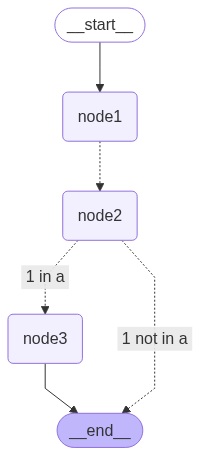

In [16]:
from IPython.display import Image, display

display(Image(g_wo_tmp.get_graph().draw_mermaid_png()))

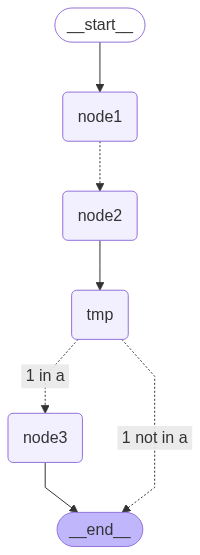

In [17]:
display(Image(g_w_tmp.get_graph().draw_mermaid_png()))

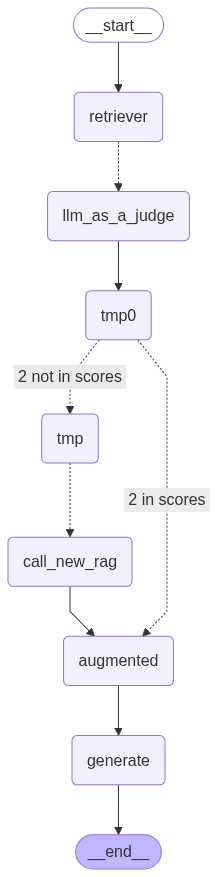

In [7]:
from IPython.display import Image, display

display(Image(rag_with_judge.get_graph().draw_mermaid_png()))

In [18]:
g_wo_tmp.invoke(input={'a': []})

2025-08-01 13:54:10.082 | INFO     | __main__:node1:16 - node1: {'a': []}
2025-08-01 13:54:10.085 | INFO     | __main__:node1_to_node2:23 - node1_to_node2: {'a': [['node1 1'], ['node1 2']]}
2025-08-01 13:54:10.088 | INFO     | __main__:node2:37 - node2: {'b': ['node1 1']}
2025-08-01 13:54:10.093 | INFO     | __main__:node2:37 - node2: {'b': ['node1 2']}
2025-08-01 13:54:10.094 | INFO     | __main__:is_1_in_a:48 - is_1_in_a: {}
2025-08-01 13:54:10.100 | INFO     | __main__:is_1_in_a:48 - is_1_in_a: {}


KeyError: 'a'

In [19]:
g_w_tmp.invoke(input={'a': []})

2025-08-01 13:57:35.671 | INFO     | __main__:node1:16 - node1: {'a': []}
2025-08-01 13:57:35.673 | INFO     | __main__:node1_to_node2:23 - node1_to_node2: {'a': [['node1 1'], ['node1 2']]}
2025-08-01 13:57:35.677 | INFO     | __main__:node2:37 - node2: {'b': ['node1 1']}
2025-08-01 13:57:35.684 | INFO     | __main__:node2:37 - node2: {'b': ['node1 2']}
2025-08-01 13:57:35.694 | INFO     | __main__:is_1_in_a:48 - is_1_in_a: {'a': [['node1 1', 1], ['node1 2', 1]]}


{'a': [['node1 1', 1], ['node1 2', 1]]}

In [1]:
from langchain_openai import ChatOpenAI
import os

llm = ChatOpenAI(
    api_key=os.getenv("BL_API_KEY"),
    base_url=os.getenv("BL_BASE_URL"),
    model='qwen-max-latest',
    temperature=0.0
)

In [2]:
from run_qa import get_qa_pair

In [9]:
get_qa_pair(
    qa_system=llm,
    config={},
    question_path='../data/hotpotqa_test_data_500.json',
    test_size=3,
    test_type='continue',
    # test_type='new',
    qa_res_path='./hotpotqa/llm_only/qa_result.json'
)

2025-07-31 19:34:44.913 | INFO     | run_qa:get_qa_pair:66 - 加载问题的索引为 [3:6]，共 3 个
回答问题: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]


In [6]:
import sys

# 需要把当前项目的根目录加到 sys.path 中，才能找到 modules 下的 Index 模块
sys.path.append('../')

In [14]:
from modules.prompt import get_rag_sys_prompt, get_input_prompt

In [11]:
a = get_rag_sys_prompt()

In [13]:
print(a.content)

You are a RAG Q&A assistant that works according to the following rules:
1. Answer questions using only the knowledge snippets provided, without using any external knowledge.
2. If the knowledge snippets contain no information that can answer the question, you must respond with "I cannot answer this question."
3. Answers must be concise and direct: output only the final answer, without explanation, references to the knowledge, or polite language.
4. If the knowledge snippets are irrelevant to the question, immediately trigger rule 2.


In [15]:
from langchain_core.documents import Document

similar_chunks = [
    Document(page_content='a'),
    Document(page_content='b'),
    Document(page_content='c'),
]


docs = [chunk.page_content + '\n' for chunk in similar_chunks]

In [19]:
b = get_input_prompt(
    query='test query',
    context=''.join(docs),
)

In [20]:
b

HumanMessage(content='[Knowledge]\na\nb\nc\n\n\n[question]\ntest query', additional_kwargs={}, response_metadata={})

In [21]:
print(b.content)

[Knowledge]
a
b
c


[question]
test query
